# Wilson's Morning Wake Up Playlist Generator, Modeling and Learning

The following steps will be executed:

* Upload your data to S3.
* Define a benchmark and candidate models and training scripts
* Train models and deploy.
* Evaluate deployed estimator.

In [11]:
# Defaults
import os
import sys

import pandas as pd
import numpy as np

from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
from sklearn.externals import joblib

In [12]:
# import boto3
# import sagemaker

In [13]:
# # session and role
# sagemaker_session = sagemaker.Session()
# role = sagemaker.get_execution_role()

# # create an S3 bucket
# bucket = sagemaker_session.default_bucket()

In [14]:
!ls -la data

'ls' is not recognized as an internal or external command,
operable program or batch file.


## Upload your training data to S3

In [15]:
# should be the name of directory you created to save your features data
data_dir = 'data'

In [16]:
# # set prefix, a descriptive name for a directory  
# prefix = 'sagemaker/wmw_estimator'

# # upload all data to S3
# input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

---

# Modeling

It's time to define and train the models!

---

## Complete a training script 

To implement a custom estimator, I need to complete a `train.py` script. 

A typical training script:
* Loads training data from a specified directory
* Parses any training & model hyperparameters (ex. nodes in a neural network, training epochs, etc.)
* Instantiates a model of your design, with any specified hyperparams
* Trains that model 
* Finally, saves the model so that it can be hosted/deployed, later

### Defining and training a model

To complete a `train.py` file, you will:
1. Import any extra libraries you need
2. Define any additional model training hyperparameters using `parser.add_argument`
2. Define a model in the `if __name__ == '__main__':` section
3. Train the model in that same section


In [17]:
# Directory of train.py
!pygmentize model/train.py

Error: cannot read infile: [Errno 2] No such file or directory: 'model/train.py'


---
# Create an Estimator

When a custom model is constructed in SageMaker, an entry point must be specified. This is the Python file which will be executed when the model is trained; the `train.py` function you specified above. To run a custom training script in SageMaker, construct an estimator, and fill in the appropriate constructor arguments:

* **entry_point**: The path to the Python script SageMaker runs for training and prediction.
* **source_dir**: The path to the training script directory `source_sklearn` OR `source_pytorch`.
* **entry_point**: The path to the Python script SageMaker runs for training and prediction.
* **source_dir**: The path to the training script directory `train_sklearn` OR `train_pytorch`.
* **entry_point**: The path to the Python script SageMaker runs for training.
* **source_dir**: The path to the training script directory `train_sklearn` OR `train_pytorch`.
* **role**: Role ARN, which was specified, above.
* **train_instance_count**: The number of training instances (should be left at 1).
* **train_instance_type**: The type of SageMaker instance for training. Note: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
* **sagemaker_session**: The session used to train on Sagemaker.
* **hyperparameters** (optional): A dictionary `{'name':value, ..}` passed to the train function as hyperparameters.

Note: For a PyTorch model, there is another optional argument **framework_version**, which you can set to the latest version of PyTorch, `1.0`.

## Define PyTorch estimators

In [18]:
# Build sequences and targets
def create_playlist_sequences(input_data):
    input_playlists = []
    
    for i in input_data['volume'].unique():
        temp_vol = input_data[input_data['volume'] == i]
        X = temp_vol.iloc[:, 2:11].values
        y = temp_vol.iloc[:, 11:].values
        input_playlists.append((X, y))
        
    return input_playlists

In [19]:
from unittest.mock import MagicMock, patch

def _print_success_message():
    print('Tests Passed!')

def test_playlist_sequences(input_playlists):
    
    track_features = [-2.39099487, -2.63509459, -0.27732204,  0.92969533, -0.48983686,-1.15691947,  1.08569029, -1.20454903,  2.09618458, -5.37044178, 0.23380331]
    
    track_features_len = 11
    target_features_len = 8
    
    # check shape and equality of first track
    assert len(input_playlists[0][0][0]) == len(track_features), \
        'Number of features in input_playlist features does not match expected number of ' + str(len(track_features))    
    
    # check shape of input and output arrays
    assert input_playlists[0][0].shape[1]==track_features_len, \
        'input_features should have as many columns as selected features, got: {}'.format(train_x.shape[1])
    assert input_playlists[0][1].shape[1]==target_features_len, \
        'target_features should have as many columns as selected features, got: {}'.format(train_x.shape[1])
    
    #TODO: Add more tests
    
    _print_success_message()

### Test run of benchmark and candidate models and train components
Here I will see if the configurations I have set work accordingly with no errors. Once it runs smoothly, I will instantiate an estimator using the Sagemaker API.

In [20]:
import os
import torch
import torch.utils.data

train_data = pd.read_csv(os.path.join(data_dir, "train.csv"))

# Gather sequences and targets
processed_data = create_playlist_sequences(train_data)

In [11]:
# Training function for LSTM
def train_lstm(model, train_loader, epochs, criterion, optimizer, device):
    """
    This is the training method that is called by the PyTorch training script of the LSTM model. The parameters
    passed are as follows:
    model        - The PyTorch model that we wish to train.
    train_loader - The PyTorch DataLoader that should be used during training.
    epochs       - The total number of epochs to train for.
    criterion    - The loss function used for training. 
    optimizer    - The optimizer to use during training.
    device       - Where the model and data should be loaded (gpu or cpu).
    """
    
    # training loop is provided
    for epoch in range(1, epochs + 1):
        
        model.train() # Make sure that the model is in training mode.

        total_loss = 0

        for batch in train_loader:
            
            # get data
            batch_x, batch_y = batch
            
            # 
            batch_x = torch.from_numpy(batch_x).float().squeeze()
            batch_y = torch.from_numpy(batch_y).float()

            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_dim),
                torch.zeros(1, 1, model.hidden_layer_dim))

            # get predictions from model
            y_pred = model(batch_x)
            
            # perform backprop
            loss = criterion(y_pred, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data.item()
            
        if epoch%25 == 1:
            print("Epoch: {}, Loss: {}".format(epoch, total_loss / len(train_loader)))

In [12]:
import torch.optim as optim
from model.LSTM_Estimator import LSTMEstimator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMEstimator(9, 30, 1, 9)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.L1Loss()

train_lstm(model, processed_data, 1000, loss_fn, optimizer, device)

Epoch: 1, Loss: 0.6886074124155818
Epoch: 26, Loss: 0.5632773573334152
Epoch: 51, Loss: 0.5213864131553753
Epoch: 76, Loss: 0.4847756447018804
Epoch: 101, Loss: 0.4545924856856063
Epoch: 126, Loss: 0.42713657343709793
Epoch: 151, Loss: 0.4087128172049651
Epoch: 176, Loss: 0.38692552173459854
Epoch: 201, Loss: 0.3738217353820801
Epoch: 226, Loss: 0.3620191611148216
Epoch: 251, Loss: 0.35060801538261205
Epoch: 276, Loss: 0.33977388127430064
Epoch: 301, Loss: 0.3361087964998709
Epoch: 326, Loss: 0.31869314812325145
Epoch: 351, Loss: 0.31551769214707454
Epoch: 376, Loss: 0.30925770103931427
Epoch: 401, Loss: 0.3043729022548005
Epoch: 426, Loss: 0.30032848506360443
Epoch: 451, Loss: 0.2949354535824544
Epoch: 476, Loss: 0.28729108700881134
Epoch: 501, Loss: 0.28241268968259964
Epoch: 526, Loss: 0.2768073702180708
Epoch: 551, Loss: 0.2743604344290656
Epoch: 576, Loss: 0.2728642990460267
Epoch: 601, Loss: 0.2696075995226164
Epoch: 626, Loss: 0.2625140140990953
Epoch: 651, Loss: 0.2622708444659

In [16]:
# Save
torch.save(model.state_dict(), 'artefacts/model.pth')

In [94]:
# Spotify API
import spotipy
import spotipy.util as util

# Spotify for developers client auth variables
username = os.environ['SPOTIFY_EMAIL']
spotify_id = os.environ['SPOTIFY_ID']
spotify_secret = os.environ['SPOTIFY_SECRET']

# Set API scope
scope='playlist-read-private, playlist-modify-private, playlist-modify-public'

# Get auth token
token = util.prompt_for_user_token(username, 
                                   scope,
                                   client_id=spotify_id,
                                   client_secret=spotify_secret,
                                   redirect_uri='http://localhost/')

In [95]:
from spotipy.oauth2 import SpotifyClientCredentials

#Authenticate
sp = spotipy.Spotify(
    client_credentials_manager = SpotifyClientCredentials(
        client_id=spotify_id,
        client_secret=spotify_secret
    )
)

In [69]:
# Read in WMW tracks to date for recommendations
track_data = pd.read_csv(os.path.join(data_dir, "wmw_tracks.csv"))

track_data.head()

,volume,position,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,38,1,Finding It There,Goldmund,0.187,0.00257,1,-37.134,1,0.0427,...,0.0915,0.0374,123.707,audio_features,6CnPCuUcM3A5PMP4gUy0vw,spotify:track:6CnPCuUcM3A5PMP4gUy0vw,https://api.spotify.com/v1/tracks/6CnPCuUcM3A5...,https://api.spotify.com/v1/audio-analysis/6CnP...,220120,5
1,38,2,Light Forms,Rohne,0.671,0.54500,10,-12.848,0,0.0393,...,0.1180,0.2840,133.036,audio_features,6MkUPsz5hYeneo0a9H0VT8,spotify:track:6MkUPsz5hYeneo0a9H0VT8,https://api.spotify.com/v1/tracks/6MkUPsz5hYen...,https://api.spotify.com/v1/audio-analysis/6MkU...,265870,4
2,38,3,C-Side,Khruangbin,0.688,0.77900,11,-10.129,0,0.0579,...,0.3490,0.9380,94.073,audio_features,6GvAM8oyVApQHGMgpBt8yl,spotify:track:6GvAM8oyVApQHGMgpBt8yl,https://api.spotify.com/v1/tracks/6GvAM8oyVApQ...,https://api.spotify.com/v1/audio-analysis/6GvA...,283407,4
3,38,4,Didn't I (Dave Allison Rework),Darondo,0.539,0.70500,0,-6.729,1,0.0527,...,0.1330,0.6850,186.033,audio_features,1owjOeZt1BdYWW6T8fIAEe,spotify:track:1owjOeZt1BdYWW6T8fIAEe,https://api.spotify.com/v1/tracks/1owjOeZt1BdY...,https://api.spotify.com/v1/audio-analysis/1owj...,328000,4
4,38,5,Woman Of The Ghetto - Akshin Alizadeh Remix,Marlena Shaw,0.707,0.57300,7,-8.403,0,0.0276,...,0.0858,0.1890,100.006,audio_features,2h8cQH7zhUWrynZi2MKhhC,spotify:track:2h8cQH7zhUWrynZi2MKhhC,https://api.spotify.com/v1/tracks/2h8cQH7zhUWr...,https://api.spotify.com/v1/audio-analysis/2h8c...,302467,4


In [70]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

pca.fit(track_data[feature_list])

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[9.49632173e-01 4.97587396e-02 2.33959882e-04]
[491.49839801 112.50688028   7.71462986]


In [66]:
from mpl_toolkits import mplot3d

import numpy as np
import matplotlib.pyplot as plt

In [74]:
#TODO- Save StandarScaler for later us
from pickle import dump

# save the scaler
dump(pca, open('dim_red.pkl', 'wb'))

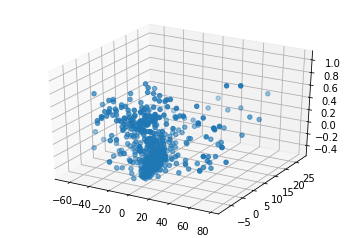

In [73]:
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df[:,0], pca_df[:,1], pca_df[:,2])
plt.show()

In [71]:
pca_df = pca.transform(track_data[feature_list])

array([[ 4.36220894e+00,  2.62242177e+01,  2.20013556e-01],
       [ 1.39826515e+01,  2.04964369e+00, -1.09662254e-01],
       [-2.49435282e+01, -1.19130395e+00,  3.81116247e-01],
       ...,
       [ 3.71216192e-02, -5.30568973e+00,  3.97253658e-01],
       [ 9.97438835e-01, -3.96836317e+00, -2.24355491e-01],
       [ 8.99963313e+00, -1.80496344e+00, -4.41656957e-03]])

In [100]:
import random
from tqdm.notebook import tqdm
from sklearn.externals import joblib
import torch.optim as optim
from model.LSTM_Estimator import LSTMEstimator

# Feature set
feature_list =  ['danceability','energy', 'loudness', 'speechiness', 'acousticness',
                 'instrumentalness', 'liveness', 'valence', 'tempo']

#'mode','key','tempo'

# Load model
model = LSTMEstimator(9, 30, 1, 9)
model.load_state_dict(torch.load('model.pth'))
model.eval()

std_scaler = joblib.load('standard_features.pkl')
dim_red = joblib.load('dim_red.pkl')

class Playlist():
    def __init__(self, wmw_pool):
        self.name = "Wilson's Morning Wake Up Vol. Test"
#         self.intro_songs = []
#         self.search_results = []
        self.recommended_track_ids = pd.DataFrame() #list of track ids straight from spotify
        self.trax = [] #all tracks as dict
        self.df = None #this is where the data goes
        self.playlist = None
        self.wmw_pool_df = wmw_pool
       
        # DO EVERYTHING
        self.intro_track = self.get_first_track()
        self.new_playlist = self.predict_playlist(model, self.intro_track)

    
    def get_first_track(self):
        
        # Sample an intro song from the WMW history
        song = self.wmw_pool_df[self.wmw_pool_df['position'] == 1].sample(1).copy()

        # Gather a recommendation based on the intro track using spotify
        song_res = sp.recommendations(seed_tracks = song['id'].values, limit=1)
        
        # Gather track freatures from spotify result
        for r in song_res['tracks']:
            track={}
            track['id'] = r['id']
            track['artists'] = [i['name'] for i in r['artists']],
            track['name'] = r['name']
            track_features = sp.audio_features(r['id'])[0]
            track.update(track_features)
            self.intro_track = pd.DataFrame(track, index=[0])

        # Prepare features
        self.intro_track[feature_list] = std_scaler.transform(self.intro_track[feature_list])
        
        return self.intro_track
    
    def harmonic_match(self, key, mode):
    
        # Harmonic Mixing Wheel: Pitch Class 
        # 1A 0 - A flat minor: 8 | 1B 0 - B major: 11
        # 2A 1 - E flat minor: 3 | 2B 1 - F-sharp major: 6
        # 3A 2 - B-flat minor: 10 | 3B 2 - D-flat major: 1
        # 4A 3 - F minor: 5 | 4B 3 - A-flat major: 8
        # 5A 4 - C minor: 0 | 5B 4 - E-flat major: 3
        # 6A 5 - G minor: 7 | 6B 5 - B-flat major: 10
        # 7A 6 - D minor: 2 | 7B 6 - F major: 5
        # 8A 7 - A minor: 9 | 8B 7 - C major: 0
        # 9A 8 - E minor: 4 | 9B 8 - G major: 7
        # 10A 9 - B minor: 11 | 10B 9 - D major: 2
        # 11A 10 - F sharp minor: 6 | 11B 10 - A major: 9
        # 12A 11 - D flat minor: 1 | 12B 11 - E major: 4

        # Harmonic keys mapped to corresponding pitch classes
        pitch_to_harmonic_keys = {0: [4, 7], 1: [11, 2], 2: [6, 9],
                                  3: [1, 4], 4: [8, 11], 5: [3, 6],
                                  6: [10, 1], 7: [5, 8], 8: [0, 3],
                                  9: [7, 10], 10: [2, 5], 11: [9, 0]}

        # Extract values and keys
        dv = np.array(list(pitch_to_harmonic_keys.values()))
        dk = np.array(list(pitch_to_harmonic_keys.keys()))

        # Harmonic key code corresponding song pitch class
        harm_key = dv[np.where(dk == key)][0][mode]

        # Harmonic key codes
        harmonic_keys = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

        # Get compatible key codes
        comp_keycodes = np.take(harmonic_keys, 
                                [harm_key - 1, harm_key, harm_key + 1],
                                mode='wrap')

        # Compatible keys
        comp_keys = [np.where(dv[:, mode] == i)[0][0].tolist() for i in comp_keycodes]

        # Compatible up/down key
        inner_outer_key = np.array([np.where(dv[:, int(not bool(mode))] == harm_key)[0][0]])

        comp_keys = np.concatenate([comp_keys, inner_outer_key])

        print("Compatible keys:", comp_keys)
        
        return comp_keys, inner_outer_key
    
    
    def get_position_recommendations(self, track_position):
    
        recommendations = pd.DataFrame()

        wmw_sample = random.sample(self.wmw_pool_df['volume'].unique().tolist(), 10)

        wmw_sample_df = track_data[self.wmw_pool_df['volume'].isin(wmw_sample)].copy()

        wmw_sample_df = wmw_sample_df[self.wmw_pool_df['position'] == track_position + 1].copy()

        # Iterate full catalog of WMW songs
        for _, row in wmw_sample_df.iterrows():
            
            song_search = row['track_name'].partition('-')[0] + ' ' + row['artist_name']
            
            try:

                # Query Spotify to get track metadata
                song_res = sp.search(song_search, limit=1)['tracks']['items'][0]

                # Gather recommendations for each of the past WMW tracks
                results = sp.recommendations(seed_tracks = [song_res['id']], limit=15)

                for r in results['tracks']:
                    track={}
                    track['id'] = r['id']
                    track['artists'] = [i['name'] for i in r['artists']],
                    track['name'] = r['name']
                    track_features = sp.audio_features(r['id'])[0]
                    track.update(track_features)
                    final_track = pd.DataFrame(track, index=[0])
                    recommendations = recommendations.append(final_track, ignore_index=True)

            except:
                print("Song not searchable")

        recommendations[feature_list] = std_scaler.transform(recommendations[feature_list])

        return recommendations
    

    def predict_playlist(self, model, intro_track, predict_len=15):
        
        # Prepare prediction list
        predicted = intro_track
        
        # Prepare initial input 
        inp = torch.FloatTensor(intro_track[feature_list].values)

        print("Intro track:", predicted['name'].values[0], '-',predicted['artists'].values[0])

        for p in tqdm(range(1, predict_len)):
            print("Song position:", p + 1)

            # Generate output feature set of next song
            output = model(inp).detach().numpy()

            # Get mode and key from last song and generate compatible keys and modes
            keys, outer_inner_key = harmonic_match(predicted.iloc[-1]['key'], predicted.iloc[-1]['mode'])

            # Get recommended tracks for current track position
            sample = self.get_position_recommendations(p + 1)
            sample = sample[~sample['id'].isin(track_data['id'].values.tolist())].copy()

            # Gather compatible next songs
            harmonic_next_songs = sample[(sample['key'].isin(keys) & sample['mode'] == predicted.iloc[-1]['mode'])].reset_index(drop=True)
            
            # Ensure no duplicates
            harmonic_next_songs = harmonic_next_songs[~harmonic_next_songs['key'].isin(predicted['id'])]
            
            # Pick song at closest distance to current song
            harmonic_next_comps = dim_red.transform(harmonic_next_songs[feature_list])
            output_comp = dim_red.transform(output)
            next_song_id = np.argmin(cdist(output_comp, harmonic_next_comps))
            next_song = harmonic_next_songs.iloc[next_song_id].copy()
            
            print(next_song['name'], '-', next_song['artists']) 

            # Set new input vector for next song
            inp = torch.FloatTensor([next_song[feature_list]])

            # Append next song to playlist
            predicted = predicted.append(next_song, ignore_index=True)

        return predicted


In [101]:
pl = Playlist(track_data)

Intro track: Descending - ['Tom Day']


Song position: 2
Compatible keys: [ 9  4 11  1]


C:\Users\gilleal\AppData\Local\Continuum\anaconda3\envs\local_wmw\lib\site-packages\ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Having a Coke with You - ['New Jackson']
Song position: 3
Compatible keys: [ 6  1  8 10]


C:\Users\gilleal\AppData\Local\Continuum\anaconda3\envs\local_wmw\lib\site-packages\ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Pinata - ['Montgomery']
Song position: 4
Compatible keys: [ 6  1  8 10]


C:\Users\gilleal\AppData\Local\Continuum\anaconda3\envs\local_wmw\lib\site-packages\ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Eating Hooks - Siriusmo Remix - Solomun Edit - ['Moderat', 'Siriusmo', 'Solomun']
Song position: 5
Compatible keys: [1 8 3 5]


C:\Users\gilleal\AppData\Local\Continuum\anaconda3\envs\local_wmw\lib\site-packages\ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


BTSTU (Edit) - ['Jai Paul']
Song position: 6
Compatible keys: [ 6  1  8 10]


C:\Users\gilleal\AppData\Local\Continuum\anaconda3\envs\local_wmw\lib\site-packages\ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Honey - ['Moby']
Song position: 7
Compatible keys: [1 8 3 5]


C:\Users\gilleal\AppData\Local\Continuum\anaconda3\envs\local_wmw\lib\site-packages\ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Just the Two of Us (feat. Bill Withers) - ['Grover Washington, Jr.', 'Bill Withers']
Song position: 8
Compatible keys: [ 6  1  8 10]


C:\Users\gilleal\AppData\Local\Continuum\anaconda3\envs\local_wmw\lib\site-packages\ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Song not searchable
Pyor - ['Darius']
Song position: 9
Compatible keys: [1 8 3 5]


C:\Users\gilleal\AppData\Local\Continuum\anaconda3\envs\local_wmw\lib\site-packages\ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Sturm - ['Monkey Safari']
Song position: 10
Compatible keys: [ 6  1  8 10]


C:\Users\gilleal\AppData\Local\Continuum\anaconda3\envs\local_wmw\lib\site-packages\ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Cosmic Perspective - ['Mndsgn']
Song position: 11
Compatible keys: [1 8 3 5]


C:\Users\gilleal\AppData\Local\Continuum\anaconda3\envs\local_wmw\lib\site-packages\ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Informal Disco - ['Amtrac']
Song position: 12
Compatible keys: [1 8 3 5]


C:\Users\gilleal\AppData\Local\Continuum\anaconda3\envs\local_wmw\lib\site-packages\ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Enough to Believe - Jamie Jones Remix - ['Bob Moses', 'Jamie Jones']
Song position: 13
Compatible keys: [ 6  1  8 10]


C:\Users\gilleal\AppData\Local\Continuum\anaconda3\envs\local_wmw\lib\site-packages\ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Eating Hooks - Siriusmo Remix - Solomun Edit - ['Moderat', 'Siriusmo', 'Solomun']
Song position: 14
Compatible keys: [1 8 3 5]


C:\Users\gilleal\AppData\Local\Continuum\anaconda3\envs\local_wmw\lib\site-packages\ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Song not searchable
Innerbloom - ['RÜFÜS DU SOL']
Song position: 15
Compatible keys: [ 8  3 10  0]


C:\Users\gilleal\AppData\Local\Continuum\anaconda3\envs\local_wmw\lib\site-packages\ipykernel_launcher.py:118: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Nothing Without You - ['Tinlicker', 'Thomas Oliver']



In [86]:
pl.new_playlist

,id,artists,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,5JhhawSlXCSYcu48LafOIn,[Port Blue],Into The Sea,0.212763,0.353626,1,0.334509,1,-0.378234,-0.788329,0.319844,-0.302243,-0.442613,-0.433693,audio_features,spotify:track:5JhhawSlXCSYcu48LafOIn,https://api.spotify.com/v1/tracks/5JhhawSlXCSY...,https://api.spotify.com/v1/audio-analysis/5Jhh...,142173,4
1,1IYISeYvuX8gobY24B4wkJ,[Aaron Taylor],Blue,1.281929,-1.761784,8,0.551836,1,-0.480956,1.129129,-1.689678,-0.339898,0.225871,-0.528807,audio_features,spotify:track:1IYISeYvuX8gobY24B4wkJ,https://api.spotify.com/v1/tracks/1IYISeYvuX8g...,https://api.spotify.com/v1/audio-analysis/1IYI...,336291,3
2,4X8oQZ8LvTRdrjtSs2048s,[Amtrac],Never Lost,0.274338,-0.244106,1,0.533202,1,-0.402798,-0.814459,0.604348,1.075941,-0.277607,0.046044,audio_features,spotify:track:4X8oQZ8LvTRdrjtSs2048s,https://api.spotify.com/v1/tracks/4X8oQZ8LvTRd...,https://api.spotify.com/v1/audio-analysis/4X8o...,406027,4
3,5vYBWNH7CT4CSHtrPvmmiN,[Zola Blood],Play Out,0.067222,-0.253445,8,-0.506117,1,-0.293375,0.223722,0.633379,-0.467926,-0.943975,-0.144567,audio_features,spotify:track:5vYBWNH7CT4CSHtrPvmmiN,https://api.spotify.com/v1/tracks/5vYBWNH7CT4C...,https://api.spotify.com/v1/audio-analysis/5vYB...,277671,4
4,3Nr62FFbrwPRAAmKoLbR7a,[Kelpe],After Gold,-0.033537,-0.248775,1,0.241339,1,0.293932,0.083961,-0.048849,-0.332367,-0.957091,-0.588145,audio_features,spotify:track:3Nr62FFbrwPRAAmKoLbR7a,https://api.spotify.com/v1/tracks/3Nr62FFbrwPR...,https://api.spotify.com/v1/audio-analysis/3Nr6...,390987,4
5,4ecwrnFDSJLlLyZlEH7YGK,[Helios],Nothing It Can,-2.468547,-1.556314,1,-0.283346,1,-0.369301,1.496761,0.775630,-0.662981,-1.184714,-0.480004,audio_features,spotify:track:4ecwrnFDSJLlLyZlEH7YGK,https://api.spotify.com/v1/tracks/4ecwrnFDSJLl...,https://api.spotify.com/v1/audio-analysis/4ecw...,287521,4
6,0Qm14E0Scc9hpGPwhowHEP,[Liquid Stranger],Dissolve,0.240752,0.106128,6,0.627838,1,-0.581446,-0.818105,0.584026,0.390615,-0.916897,-0.671813,audio_features,spotify:track:0Qm14E0Scc9hpGPwhowHEP,https://api.spotify.com/v1/tracks/0Qm14E0Scc9h...,https://api.spotify.com/v1/audio-analysis/0Qm1...,392592,4
7,4X8oQZ8LvTRdrjtSs2048s,[Amtrac],Never Lost,0.274338,-0.244106,1,0.533202,1,-0.402798,-0.814459,0.604348,1.075941,-0.277607,0.046044,audio_features,spotify:track:4X8oQZ8LvTRdrjtSs2048s,https://api.spotify.com/v1/tracks/4X8oQZ8LvTRd...,https://api.spotify.com/v1/audio-analysis/4X8o...,406027,4
8,095g2zEZ5qWnmA5nQXMPoE,[Yungun & Mr Thing],Forget Me Not,0.095211,0.507729,1,0.652963,1,0.579769,-0.283671,-1.453947,-0.385085,0.454340,-1.095611,audio_features,spotify:track:095g2zEZ5qWnmA5nQXMPoE,https://api.spotify.com/v1/tracks/095g2zEZ5qWn...,https://api.spotify.com/v1/audio-analysis/095g...,220320,4
9,3wQ2F1MjiNMENmvy4xUeXy,"[Electric Youth, College]",A Real Hero,0.470258,-0.631697,10,0.535505,1,-0.458625,1.390421,-0.223034,0.044186,0.251256,-0.336615,audio_features,spotify:track:3wQ2F1MjiNMENmvy4xUeXy,https://api.spotify.com/v1/tracks/3wQ2F1MjiNME...,https://api.spotify.com/v1/audio-analysis/3wQ2...,267693,4


In [102]:
if token:
    sp = spotipy.Spotify(auth=token)
    sp.trace = False
    tracks = sp.user_playlist_replace_tracks('1247785541', '7x1MY3AW3YCaHoicpiacGv', pl.new_playlist['id'].values)
else:
    print("Can't get token for", username)

In [16]:
# pl = Playlist()

In [ ]:
#         self.get_predictions() # Generate features for each track position for new WMW
        
        
#     def get_recommendations(self):
#         print('Getting Recommendations...')
        
#         # Iterate full catalog of WMW songs
#         for _, row in tqdm(track_data[track_data['volume'] == 38].iterrows(), total=track_data[track_data['volume'] == 38].shape[0]):
#             song_search = row['track_name'].partition('-')[0] + ' ' + row['artist_name']
#             try:
        
#                 # Query Spotify to get track metadata
#                 song_res = sp.search(song_search, limit=1)['tracks']['items'][0]

#                 self.search_results.append({
#                     'id': song_res['id'],
#                     'artists': [i['name'] for i in song_res['artists']],
#                     'name': song_res['name']
#                 })
                
#                 # Gather recommendations for each of the past WMW tracks
#                 results = sp.recommendations(seed_tracks = [song_res['id']], limit=10)

#                 for r in results['tracks']:
#                     track={}
#                     track['id'] = r['id']
#                     track['artists'] = [i['name'] for i in r['artists']],
#                     track['name'] = r['name']
#                     track_features = sp.audio_features(r['id'])[0]
#                     track.update(track_features)
#                     final_track = pd.DataFrame(track, index=[0])
#                     self.recommended_track_ids = self.recommended_track_ids.append(final_track, ignore_index=True)
                    
#             except:
#                 print("Song not searchable")
        
#         return self.recommended_track_ids

In [17]:
# pl.recommended_track_ids.head()

In [18]:
# import random

# recommended = pd.DataFrame()

# wmw_sample = random.sample(track_data['volume'].unique().tolist(), 5)

# wmw_sample_df = track_data[track_data['volume'].isin(wmw_sample)]

# # Iterate full catalog of WMW songs
# for _, row in tqdm(wmw_sample_df.iterrows(), total=wmw_sample_df.shape[0]):
#     song_search = row['track_name'].partition('-')[0] + ' ' + row['artist_name']
#     try:

#         # Query Spotify to get track metadata
#         song_res = sp.search(song_search, limit=1)['tracks']['items'][0]

#         # Gather recommendations for each of the past WMW tracks
#         results = sp.recommendations(seed_tracks = [song_res['id']], limit=10)

#         for r in results['tracks']:
#             track={}
#             track['id'] = r['id']
#             track['artists'] = [i['name'] for i in r['artists']],
#             track['name'] = r['name']
#             track_features = sp.audio_features(r['id'])[0]
#             track.update(track_features)
#             final_track = pd.DataFrame(track, index=[0])
#             recommended = recommended.append(final_track, ignore_index=True)

#     except:
#         print("Song not searchable")

In [19]:
# recommended[feature_list] = std_scaler.transform(recommended[feature_list])

#TODO: Make sure new playlist has unique songs compared to the all previous WMWs

In [20]:
# recommended[feature_list].head()

In [24]:
def harmonic_match(key, mode):
    
    # Harmonic Mixing Wheel: Pitch Class 
    # 1A 0 - A flat minor: 8 | 1B 0 - B major: 11
    # 2A 1 - E flat minor: 3 | 2B 1 - F-sharp major: 6
    # 3A 2 - B-flat minor: 10 | 3B 2 - D-flat major: 1
    # 4A 3 - F minor: 5 | 4B 3 - A-flat major: 8
    # 5A 4 - C minor: 0 | 5B 4 - E-flat major: 3
    # 6A 5 - G minor: 7 | 6B 5 - B-flat major: 10
    # 7A 6 - D minor: 2 | 7B 6 - F major: 5
    # 8A 7 - A minor: 9 | 8B 7 - C major: 0
    # 9A 8 - E minor: 4 | 9B 8 - G major: 7
    # 10A 9 - B minor: 11 | 10B 9 - D major: 2
    # 11A 10 - F sharp minor: 6 | 11B 10 - A major: 9
    # 12A 11 - D flat minor: 1 | 12B 11 - E major: 4
    
    # Harmonic keys mapped to corresponding pitch classes
    pitch_to_harmonic_keys = {0: [4, 7], 1: [11, 2], 2: [6, 9],
                              3: [1, 4], 4: [8, 11], 5: [3, 6],
                              6: [10, 1], 7: [5, 8], 8: [0, 3],
                              9: [7, 10], 10: [2, 5], 11: [9, 0]}
    
    # Extract values and keys
    dv = np.array(list(pitch_to_harmonic_keys.values()))
    dk = np.array(list(pitch_to_harmonic_keys.keys()))

    # Harmonic key code corresponding song pitch class
    harm_key = dv[np.where(dk == key)][0][mode]
    
    # Harmonic key codes
    harmonic_keys = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    
    # Get compatible key codes
    comp_keycodes = np.take(harmonic_keys, 
                            [harm_key - 1, harm_key, harm_key + 1],
                            mode='wrap')
    
    # Compatible keys
    comp_keys = [np.where(dv[:, mode] == i)[0][0].tolist() for i in comp_keycodes]
      
    # Compatible up/down key
    inner_outer_key = np.array([np.where(dv[:, int(not bool(mode))] == harm_key)[0][0]])
    
    comp_keys = np.concatenate([comp_keys, inner_outer_key])
    
    print("Compatible keys:", comp_keys)
    
    return comp_keys, inner_outer_key

In [25]:
from unittest.mock import MagicMock, patch

def _print_success_message():
    print('Tests Passed!')

def test_harmonic_mixing(song):
    
    truth_octaves = [11, 0, 1]
    
    next_octaves = harmonic_match(0, 1)
    
    # check shape and equality of first track
    assert len(truth_octaves) == len(next_octaves), \
        'Number of octaves incorrect, should get: ' + str(len(truth_octaves))    
    
    # check shape of input and output arrays
    assert input_playlists[0][0].shape[1]==track_features_len, \
        'input_features should have as many columns as selected features, got: {}'.format(train_x.shape[1])
    assert input_playlists[0][1].shape[1]==target_features_len, \
        'target_features should have as many columns as selected features, got: {}'.format(train_x.shape[1])
    
    #TODO: Add more tests
    
    _print_success_message()

In [26]:
# Look at a track
# recommended.iloc[142]

In [27]:
import random


feature_list =  ['danceability','energy', 'loudness', 'speechiness', 'acousticness',
                 'instrumentalness', 'liveness', 'valence', 'tempo']

std_scaler = joblib.load('standard_features.pkl')

def predict_playlist(model, predict_len=15):
    global recommended
    
    intro_tracks = pd.DataFrame() #list of track ids straight from spotify
    
    model.eval()
    
    song = track_data[track_data['position'] == 1].sample(1).copy()
        
    # Gather recommendations for each of the past WMW tracks
    song_res = sp.recommendations(seed_tracks = song['id'].values, limit=1)
    
    for r in song_res['tracks']:
        track={}
        track['id'] = r['id']
        track['artists'] = [i['name'] for i in r['artists']],
        track['name'] = r['name']
        track_features = sp.audio_features(r['id'])[0]
        track.update(track_features)
        final_track = pd.DataFrame(track, index=[0])
        intro_tracks = intro_tracks.append(final_track, ignore_index=True)

    intro_tracks[feature_list] = std_scaler.transform(intro_tracks[feature_list])
            
    predicted = intro_tracks

    inp = torch.FloatTensor(intro_tracks[feature_list].values)
    
    print("Intro:", predicted['name'].values[0], '-', predicted['artists'].values[0])

    for p in tqdm(range(predict_len)):
        print("Song position:", p + 2)
        
        # Generate output feature set of next song
        output = model(inp).detach().numpy()
        
        # Get mode and key from last song and generate compatible keys and modes
        keys, outer_inner_key = harmonic_match(predicted.iloc[-1]['key'], predicted.iloc[-1]['mode'])
        
        # Get recommended tracks for song position
        sample = position_recommendation(track_data, p + 1)
        
        sample = sample[~sample['id'].isin(track_data['id'].values.tolist())].copy()
        
        # Gather compatible next songs
        harmonic_next_songs = sample[(sample['key'].isin(keys) & sample['mode'] == predicted.iloc[-1]['mode'])].reset_index(drop=True)
        
        # Pick song at closest distance to current song
        next_song_id = np.argmin(cdist(output, harmonic_next_songs[feature_list]))
        next_song = harmonic_next_songs.iloc[next_song_id].copy()
        print(next_song['name'], '-', next_song['artists']) 
        
        # Set new input vector for next song
        inp = torch.FloatTensor([next_song[feature_list]])
        
        # Append next song to playlist
        predicted = predicted.append(next_song, ignore_index=True)
        
        # Drop next song from recommended song pool
#         sample = sample.drop([next_song_id], axis=0).reset_index(drop=True)
        
    return predicted

In [28]:
def position_recommendation(track_data, song_position):
    
    recommended = pd.DataFrame()
    
    wmw_sample = random.sample(track_data['volume'].unique().tolist(), 10)

    wmw_sample_df = track_data[track_data['volume'].isin(wmw_sample)].copy()

    wmw_sample_df = wmw_sample_df[wmw_sample_df['position'] == song_position + 1].copy()

    # Iterate full catalog of WMW songs
    for _, row in wmw_sample_df.iterrows():
        song_search = row['track_name'].partition('-')[0] + ' ' + row['artist_name']
        try:

            # Query Spotify to get track metadata
            song_res = sp.search(song_search, limit=1)['tracks']['items'][0]

            # Gather recommendations for each of the past WMW tracks
            results = sp.recommendations(seed_tracks = [song_res['id']], limit=15)

            for r in results['tracks']:
                track={}
                track['id'] = r['id']
                track['artists'] = [i['name'] for i in r['artists']],
                track['name'] = r['name']
                track_features = sp.audio_features(r['id'])[0]
                track.update(track_features)
                final_track = pd.DataFrame(track, index=[0])
                recommended = recommended.append(final_track, ignore_index=True)

        except:
            print("Song not searchable")
            
    recommended[feature_list] = std_scaler.transform(recommended[feature_list])
            
    return recommended

In [36]:
%%time
new_playlist = predict_playlist(model, predict_len=14)

Intro: Odyssey - ['Rival Consoles']


Song position: 2
Compatible keys: [0 7 2 4]
Atlantic Oscillations - ['Quantic']
Song position: 3
Compatible keys: [0 7 2 4]
0404 - ['il:lo']
Song position: 4
Compatible keys: [0 7 2 4]
Unfold - ['Moods']
Song position: 5
Compatible keys: [5 0 7 9]
LesAlpx - ['Floating Points']
Song position: 6
Compatible keys: [5 0 7 9]
Everything Connected - Edit - ['Jon Hopkins']
Song position: 7
Compatible keys: [0 7 2 4]
Live Like We’re Dancing (with Georgia) - ['Mura Masa', 'Georgia']
Song position: 8
Compatible keys: [ 7  2  9 11]
Sunday - ['Rampa']
Song position: 9
Compatible keys: [ 7  2  9 11]
Crash - ['Chris Malinchak']
Song position: 10
Compatible keys: [ 7  2  9 11]
Close - ['Emika']
Song position: 11
Compatible keys: [ 7  2  9 11]
No Place - Eelke Kleijn Remix - ['RÜFÜS DU SOL', 'Eelke Kleijn']
Song position: 12
Compatible keys: [0 7 2 4]
Song not searchable
Muyè - Black Coffee Remix - ['Rampa', '&ME', 'Adam Port', 'Black Coffee']
Song position: 13
Compatible keys: [0 7 2 4]
Syria - Satori

In [32]:
if token:
    sp = spotipy.Spotify(auth=token)
    sp.trace = False
    tracks = sp.user_playlist_replace_tracks('1247785541', '7x1MY3AW3YCaHoicpiacGv', new_playlist['id'].values)
else:
    print("Can't get token for", username)

In [10]:
# if len(sys.argv) > 3:
#     username = sys.argv[1]
#     playlist_id = sys.argv[2]
#     track_ids = sys.argv[3:]
# else:
#     print("Usage: %s username playlist_id track_id ..." % (sys.argv[0],))
#     sys.exit()

# scope = 'playlist-modify-public'
# token = util.prompt_for_user_token(username, scope)

if token:
    sp = spotipy.Spotify(auth=token)
    sp.trace = False
    results = sp.playlist('7x1MY3AW3YCaHoicpiacGv')
else:
    print("Can't get token for", username)

In [11]:
results

{'collaborative': False,
 'description': 'Wilson&#x27;s AI Morning Wake Up',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/7x1MY3AW3YCaHoicpiacGv'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/playlists/7x1MY3AW3YCaHoicpiacGv',
 'id': '7x1MY3AW3YCaHoicpiacGv',
 'images': [{'height': 640,
   'url': 'https://mosaic.scdn.co/640/ab67616d0000b27357414527896ba0427a4411b0ab67616d0000b2737154ecb419796618341679c5ab67616d0000b2739d9126ec04bb005c687291a5ab67616d0000b273c8ca7badcec8eff55cdca3f4',
   'width': 640},
  {'height': 300,
   'url': 'https://mosaic.scdn.co/300/ab67616d0000b27357414527896ba0427a4411b0ab67616d0000b2737154ecb419796618341679c5ab67616d0000b2739d9126ec04bb005c687291a5ab67616d0000b273c8ca7badcec8eff55cdca3f4',
   'width': 300},
  {'height': 60,
   'url': 'https://mosaic.scdn.co/60/ab67616d0000b27357414527896ba0427a4411b0ab67616d0000b2737154ecb419796618341679c5ab67616d0000b2739d9126ec04bb005c687291a5ab67616d0000b273c8ca7badcec

In [ ]:
# # Training function
# def train_rnn(model, train_loader, epochs, criterion, optimizer, device):
#     """
#     This is the training method that is called by the PyTorch training script. The parameters
#     passed are as follows:
#     model        - The PyTorch model that we wish to train.
#     train_loader - The PyTorch DataLoader that should be used during training.
#     epochs       - The total number of epochs to train for.
#     criterion    - The loss function used for training. 
#     optimizer    - The optimizer to use during training.
#     device       - Where the model and data should be loaded (gpu or cpu).
#     """
    
#     # training loop is provided
#     for epoch in range(1, epochs + 1):
#         model.train() # Make sure that the model is in training mode.

#         total_loss = 0
        
#         hidden = model.initHidden()

#         for batch in train_loader:
            
#             # get data
#             batch_x, batch_y = batch
            
#             # 
#             batch_x = torch.from_numpy(batch_x).float().squeeze()
#             batch_y = torch.from_numpy(batch_y).float()

#             batch_x = batch_x.to(device)
#             batch_y = batch_y.to(device)

#             optimizer.zero_grad()

#             y_pred = []
            
#             # get predictions
#             for x in batch_x:
#                 y, hidden = model(x, hidden)
#                 y_pred.append(y)
            
#             # perform backprop
#             loss = criterion(y_pred, batch_y)
#             loss.backward()
#             optimizer.step()
            
#             total_loss += loss.data.item()
            
#         if epoch%25 == 1:
#             print("Epoch: {}, Loss: {}".format(epoch, total_loss / len(train_loader)))

#TODO: Create working RNN Benchmark model

In [ ]:
# import torch.optim as optim
# from model.RnnEstimator import RNNEstimator

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = RNNEstimator(11, 30, 8)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss_fn = torch.nn.L1Loss()

# train_rnn(model, processed_data, 100, loss_fn, optimizer, device)

### Build and Train the PyTorch Model with Hyperparameter Tuning

In [ ]:
# Estimator code
from sagemaker.pytorch import PyTorch
output_path = 's3://{}/{}'.format(bucket, prefix)

estimator = PyTorch(entry_point="LSTM_Train.py",
                    source_dir="model",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    output_path = output_path,
                    train_instance_type='ml.m4.xlarge',
                    hyperparameters={
                        'input_features': 11,
                        'hidden_dim': 12,
                        'output_dim': 8,
                        'epochs': 100
                    })

In [ ]:
# Fit estimator
estimator.fit({'train': input_data})

In [ ]:
%%time

# deploy your model to create a predictor
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')